In [1]:
%matplotlib inline


# EM: TDEM: 1D: Inversion


In [18]:
import numpy as np
from SimPEG.electromagnetics import time_domain
from SimPEG import (
    optimization,
    discretize,
    maps,
    data_misfit,
    regularization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
import matplotlib.pyplot as plt

## Mesh

We create the mesh grid

Text(0.5, 1.0, 'Tensor Mesh')

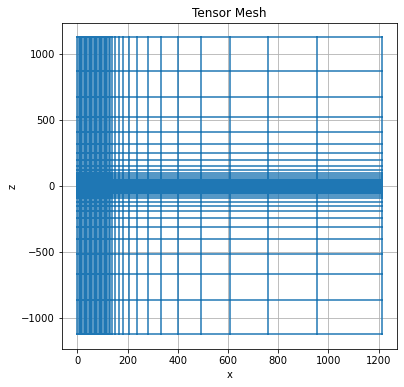

In [26]:
cs, ncx, ncz, npad = 5.0, 25, 15, 15
hx = [(cs, ncx), (cs, npad, 1.3)]
hz = [(cs, npad, -1.3), (cs, ncz), (cs, npad, 1.3)]
mesh = discretize.CylMesh([hx, 1, hz], "00C")

active = mesh.vectorCCz < 0.0
layer = (mesh.vectorCCz < 0.0) & (mesh.vectorCCz >= -100.0)
actMap = maps.InjectActiveCells(mesh, active, np.log(1e-8), nC=mesh.nCz)
mapping = maps.ExpMap(mesh) * maps.SurjectVertical1D(mesh) * actMap
sig_half = 2e-3
sig_air = 1e-8
sig_layer = 1e-3
sigma = np.ones(mesh.nCz) * sig_air
sigma[active] = sig_half
sigma[layer] = sig_layer
mtrue = np.log(sigma[active])

# We can apply the plotGrid method and output to a specified axes object
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
mesh.plotGrid(ax=ax)
ax.set_title("Tensor Mesh")

## Survey 

In [20]:
rxOffset = 1e-3
rx = time_domain.Rx.PointMagneticFluxTimeDerivative(
    np.array([[rxOffset, 0.0, 30]]), np.logspace(-5, -3, 31), "z"
)
src = time_domain.Src.MagDipole([rx], loc=np.array([0.0, 0.0, 80]))
survey = time_domain.Survey([src])
time_steps = [(1e-06, 20), (1e-05, 20), (0.0001, 20)]
simulation = time_domain.Simulation3DElectricField(
    mesh, sigmaMap=mapping, survey=survey, time_steps=time_steps
)

## Observed data 

Datas are created automatically

In [21]:
# create observed data
rel_err = 0.05
data = simulation.make_synthetic_data(mtrue, relative_error=rel_err)

dmisfit = data_misfit.L2DataMisfit(simulation=simulation, data=data)
regMesh = discretize.TensorMesh([mesh.hz[mapping.maps[-1].indActive]])
reg = regularization.Tikhonov(regMesh, alpha_s=1e-2, alpha_x=1.0)
opt = optimization.InexactGaussNewton(maxIter=5, LSshorten=0.5)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)

## Set up inversion 

In [22]:
# Create an inversion object
beta = directives.BetaSchedule(coolingFactor=5, coolingRate=2)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
inv = inversion.BaseInversion(invProb, directiveList=[beta, betaest])
m0 = np.log(np.ones(mtrue.size) * sig_half)
simulation.counter = opt.counter = utils.Counter()
opt.remember("xc")

## Inversion function and plot 

In [23]:
def inv_TDEM(plotIt = True):
    mopt = inv.run(m0)

    if plotIt:
        fig, ax = plt.subplots(1, 2, figsize=(10, 6))
        ax[0].loglog(rx.times, -invProb.dpred, "b.-")
        ax[0].loglog(rx.times, -data.dobs, "r.-")
        ax[0].legend(("Noisefree", "$d^{obs}$"), fontsize=16)
        ax[0].set_xlabel("Time (s)", fontsize=14)
        ax[0].set_ylabel("$B_z$ (T)", fontsize=16)
        ax[0].set_xlabel("Time (s)", fontsize=14)
        ax[0].grid(color="k", alpha=0.5, linestyle="dashed", linewidth=0.5)

        plt.semilogx(sigma[active], mesh.vectorCCz[active])
        plt.semilogx(np.exp(mopt), mesh.vectorCCz[active])
        ax[1].set_ylim(-600, 0)
        ax[1].set_xlim(1e-4, 1e-2)
        ax[1].set_xlabel("Conductivity (S/m)", fontsize=14)
        ax[1].set_ylabel("Depth (m)", fontsize=14)
        ax[1].grid(color="k", alpha=0.5, linestyle="dashed", linewidth=0.5)
        plt.legend(["$\sigma_{true}$", "$\sigma_{pred}$"])

## Calling funtion 

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.19e+03  2.63e+03  0.00e+00  2.63e+03    3.28e+03      0              
   1  3.19e+03  2.53e+02  7.17e-02  4.81e+02    4.08e+02      0              
   2  6.38e+02  1.09e+02  1.00e-01  1.73e+02    3.19e+02      0   Skip BFGS  
   3  6.38e+02  1.21e+01  1.59e-01  1.14e+02    1.98e+01      0              
   4  1.28e+02  1.11e+01  1.61e-01  3.16e+01    8.77e+01      0   Skip BFGS  
   5  1.28e+02  9.51e-01  1.88e-01  2.50e+01    6.26e+00      0              
------------------------- STOP! -------------------------


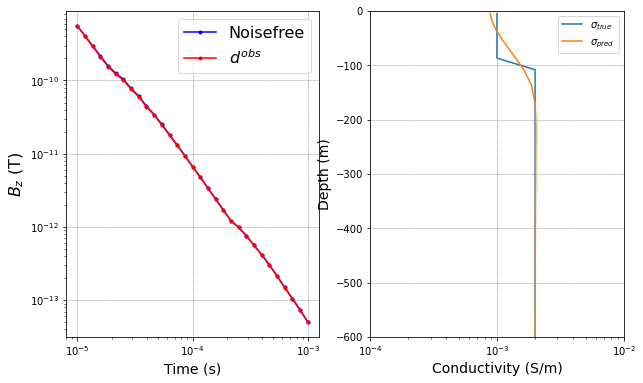

In [24]:
if __name__ == "__main__":
    inv_TDEM()

Things to do :

- Set up datas that fit our case (permafrost, air and dry/wet sediments